# Classifier-Free Guidance (CFG)

The theoretical basics and implementations of CFG.

Written by Junkun Yuan (yuanjk0921@outlook.com).

Last updated on June 16, 2025; &nbsp; First committed on March 2, 2025.

See more reading papers and notes [here](https://junkunyuan.github.io/paper_reading_list/htmls/paper_reading_list.html).

**References**
- [**Classifier-Free Diffusion Guidance** *(NeurIPS workshop 2021)*](https://arxiv.org/pdf/2207.12598): The paper which proposes the CFG algorithm.
- [**Understanding Diffusion Models: A Unified Perspective** *(arXiv 2022)*](https://arxiv.org/pdf/2208.11970): A theoretical introduction to diffusion models and other generative models.

**Contents**
- Guidance
- Classifier Guidance
- Classifier-Free Guidance
- PyTorch Implementations

## Guidance

We aim to learn **conditional data distribution $p(\boldsymbol{x}|y)$**, where condition $y$ (e.g., text prompts) controls the generation.

Simply, we can add condition $y$ at each timestep by:

<font color=red>

$$
p(\boldsymbol{x}_{0:T}|y)=p(\boldsymbol{x}_T)\prod_{t=1}^Tp_{\boldsymbol{\theta}}(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t, y).
$$

</font>

We thus learn a diffusion model by predicting $\hat{\boldsymbol{\epsilon}}_{\boldsymbol{\theta}}(\boldsymbol{x}_t,t, y)\approx\boldsymbol{\epsilon}_0$ rather than $\hat{\boldsymbol{\epsilon}}_{\boldsymbol{\theta}}(\boldsymbol{x}_t,t)\approx\boldsymbol{\epsilon}_0$.

**Guidance** is therefore proposed as a way to more explicitly control **the amount of weight** the model gives to the condition.

## Classifier Guidance

Let the learning object of score-based formulation of diffusion models with condition $y$ being $\nabla\log p(\boldsymbol{x}_t|y)$, we have

\begin{equation}
\begin{aligned}
\nabla\log p(\boldsymbol{x}_t|y)=&\nabla\log(\frac{p(\boldsymbol{x}_t)p(y|\boldsymbol{x}_t)}{p(y)}) \\
=&\nabla\log p(\boldsymbol{x}_t) + \nabla\log p(y|\boldsymbol{x}_t) - \nabla\log p(y) \\
=&\textcolor{#FF0000}{\underbrace{\nabla\log p(\boldsymbol{x}_t)}_{\text{unconditional score}} + \underbrace{\nabla\log p(y|\boldsymbol{x}_t)}_{\text{adversarial gradient}}}.
\end{aligned}
\end{equation}

It can be interpreted as learning an unconditional score function with the adversarial gradient of a classifier $p(y|\boldsymbol{x}_t)$.

A hyper-parameter $\gamma$ is given to introduce fine-grained control of how heavily the generation adhere to the condition: 

$$
\textcolor{#FF0000}{\nabla\log p(\boldsymbol{x}_t|y) = \nabla\log p(\boldsymbol{x}_t) + \gamma\nabla\log p(y|\boldsymbol{x}_t)}.
$$

This would come **at the cost of sample diversity**, as it would generate data that would be easy to regenerate the condition from</u>. 

One noted drawback is its **reliance on a separately learned classifier**. Because the classifier must handle arbitrarily noisy inputs, which existing pre-trained classification models are not optimized to do, *it must be learned alongside the diffusion model*.

## Classifier-Free Guidance

Reformulate the classifier guidance:

\begin{equation}
\begin{aligned}
\nabla\log p(\boldsymbol{x}_t|y) = & \nabla\log p(\boldsymbol{x}_t) + \gamma\nabla\log p(y|\boldsymbol{x}_t) \\
=& \nabla\log p(\boldsymbol{x}_t) + \gamma(\nabla\log p(\boldsymbol{x}_t|y) - \nabla\log p(\boldsymbol{x}_t)) \\
=& \textcolor{#FF0000}{\underbrace{\gamma\nabla\log p(\boldsymbol{x}_t|y)}_{\text{conditional score}} + \underbrace{(1 - \gamma)\nabla\log p(\boldsymbol{x}_t)}_{\text{unconditional score}} \ \ \text{[Eq. (6) of the CFG paper]}} \\
=& \textcolor{#FF0000}{\underbrace{\nabla\log p(\boldsymbol{x}_t)}_{\text{unconditional score}} + \underbrace{ \gamma(\nabla\log p(\boldsymbol{x}_t|y) - \nabla\log p(\boldsymbol{x}_t))}_{\text{conditional score - unconditional score}}}.
\end{aligned}
\end{equation}

We now can perform conditional generation **without using a specific classifier**.

Specifically, we can learn both the conditional and unconditional models together where <font color=red>the unconditional model can be queried by replacing conditions with fixed constants such as zeros</font>. We often perform <font color=red>random condition dropout</font>  to achieve it.

## PyTorch Implementations

In [2]:
## --------------------------------------------------------------------------------
## Prepare dataset and data loader
## --------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # (0, 1) -> (-1, 1)
])
## We use MNIST-10
dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=8)

In [3]:
## --------------------------------------------------------------------------------
## Build a diffusion model
## --------------------------------------------------------------------------------
from diffusers import UNet2DModel

def get_model():
    model = UNet2DModel(
        sample_size=28,  # input sample size, MNIST is 28
        in_channels=1,  # input channels
        out_channels=1,  # output channels
        layers_per_block=2,  # how many ResNet layers per UNet block
        block_out_channels=(32, 64, 128),  # the number of output channels for each UNet block
        down_block_types=(
            "DownBlock2D",  # a regular ResNet downsampling block
            "DownBlock2D",
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",  # a regular ResNet upsampling block
            "UpBlock2D",
            "UpBlock2D",
        ),
        class_embed_type="timestep",  # add embedding layer to inject condition
        num_class_embeds=10,  # 10 classes
    )
    return model

In [4]:
## --------------------------------------------------------------------------------
## Prepare training
## --------------------------------------------------------------------------------
import torch
from diffusers import DDPMScheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_optimizer(model):
    return torch.optim.AdamW(model.parameters(), lr=2e-3)

## Build DDPM scheduler
scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear"
)

In [5]:
## --------------------------------------------------------------------------------
## Prepare inference pipeline
## --------------------------------------------------------------------------------
from PIL import Image
import numpy as np
from diffusers.utils import make_image_grid

class MyDDPMPipeline:
    def __init__(self, device):
        self.device = device
 
    def tensor2pil(self, tensor, new_size):
        tensor = tensor.to("cpu").repeat(1, 3, 1, 1).permute(0, 2, 3, 1)
        tensor = torch.clamp((tensor + 1) / 2 * 255, min=0, max=255)
        images = tensor.numpy().astype(np.uint8)
        images = [Image.fromarray(t).resize((new_size, new_size), resample=Image.Resampling.LANCZOS) for _, t in enumerate(images)]
        return images
    
    @torch.no_grad()
    def __call__(self, model, scheduler, image_size=28, cfg=3., batch_size=20):
        model.eval()

        ## Sample random noises
        x = torch.randn((batch_size, 1, image_size, image_size), device=self.device)

        ## Get condition and uncondition classes
        labels = torch.arange(0, 10, device=device).repeat(2)[:batch_size]
        
        ## Set denoising steps
        scheduler.set_timesteps(num_inference_steps=1000)

        ## Denoising
        for t in scheduler.timesteps:
            ## Build input for unconditional and conditional generation
            model_input = torch.cat([x] * 2)
            timesteps = torch.cat([t.unsqueeze(0).repeat(batch_size)] * 2).to(device=device)
            all_labels = torch.cat([labels, -10 * torch.ones_like(labels)])

            ## Forward
            noise_pred = model(model_input, timesteps, class_labels=all_labels).sample

            ## Apply classifier-free guidance
            noise_pred_cond, noise_pred_uncond = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + cfg * (noise_pred_cond - noise_pred_uncond)
            
            ## Denoise from timestep t to t-1
            x = scheduler.step(noise_pred, t, x).prev_sample

        # Show results
        images = self.tensor2pil(x, new_size=int(image_size * 2))
        image_grid = make_image_grid(images, rows=1, cols=batch_size)
        display(image_grid)

sampler = MyDDPMPipeline(device)

=> Training with cfg_drop_probs 0.0
=> Epoch: 1/12, loss: 0.0544293150305748, time cost 16.9 s
=> Epoch: 5/12, loss: 0.031450796872377396, time cost 49.8 s
=> Epoch: 10/12, loss: 0.02689575031399727, time cost 131.8 s
=> Epoch: 12/12, loss: 0.027906792238354683, time cost 165.0 s


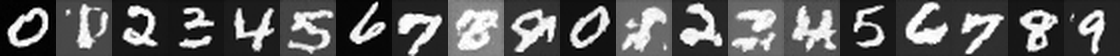

=> Training with cfg_drop_probs 0.1
=> Epoch: 1/12, loss: 0.05097873508930206, time cost 16.8 s
=> Epoch: 5/12, loss: 0.02881847694516182, time cost 83.7 s
=> Epoch: 10/12, loss: 0.028949016705155373, time cost 167.8 s
=> Epoch: 12/12, loss: 0.026151780039072037, time cost 201.6 s


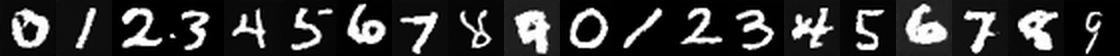

=> Training with cfg_drop_probs 0.3
=> Epoch: 1/12, loss: 0.05170053988695145, time cost 16.7 s
=> Epoch: 5/12, loss: 0.029720528051257133, time cost 84.0 s
=> Epoch: 10/12, loss: 0.024684734642505646, time cost 167.6 s
=> Epoch: 12/12, loss: 0.023824870586395264, time cost 201.2 s


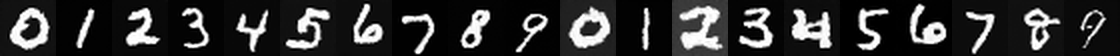

=> Training with cfg_drop_probs 0.5
=> Epoch: 1/12, loss: 0.05267065763473511, time cost 16.7 s
=> Epoch: 5/12, loss: 0.02843584679067135, time cost 84.0 s
=> Epoch: 10/12, loss: 0.025121238082647324, time cost 168.0 s
=> Epoch: 12/12, loss: 0.02789980359375477, time cost 201.5 s


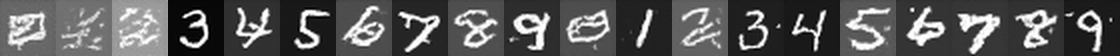

=> Training with cfg_drop_probs 1
=> Epoch: 1/12, loss: 0.055477213114500046, time cost 16.8 s
=> Epoch: 5/12, loss: 0.03434549644589424, time cost 84.0 s
=> Epoch: 10/12, loss: 0.029353879392147064, time cost 168.1 s
=> Epoch: 12/12, loss: 0.028799908235669136, time cost 201.5 s


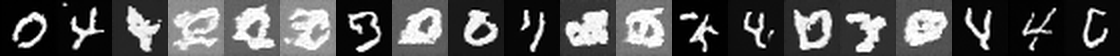

In [6]:
## --------------------------------------------------------------------------------
## Train
## --------------------------------------------------------------------------------
import time
import torch.nn.functional as F

epochs = 12
cfg_drop_probs = [0., 0.1, 0.3, 0.5, 1]  # random condition dropout
models = dict()
for cfg_drop_prob in cfg_drop_probs:
    print(f"=> Training with cfg_drop_probs {cfg_drop_prob}")
    model = get_model()
    model = model.to(device=device)
    optimizer = get_optimizer(model)
    start_time = time.time()
    for epoch in range(1, epochs + 1):
        model.train()
        for step, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            
            ## Random condition dropout
            mask = torch.rand(len(labels)) < cfg_drop_prob
            labels[mask] = -10
            
            ## Add noises to images
            noise = torch.randn_like(images)
            timesteps = torch.randint(
                0, scheduler.config.num_train_timesteps,
                (images.shape[0],), device=device
            ).long()
            noisy_images = scheduler.add_noise(images, noise, timesteps)
            
            ## Forward
            noise_pred = model(noisy_images, timesteps, class_labels=labels).sample
            
            ## Backward
            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch == 1 or epoch % 5 == 0 or epoch == epochs:
            end_time = time.time()
            print(f"=> Epoch: {epoch}/{epochs}, loss: {loss.cpu().item()}, time cost {end_time - start_time:.1f} s")
    models[cfg_drop_prob] = model
    sampler(model, scheduler, cfg=3)

**Observations:**

- Keep *all conditions* during training achieves *limited* performane.
- Drop a *proper proportion* of conditions such as *10%* and *30%* both achieve *good* performance.
- Drop a *high proportion* of data such as 50% or even 100% is *detrimental* to performance.
- A good way to choose good training guidance scale is to observe the loss value.  

=> Inference with cfg -10


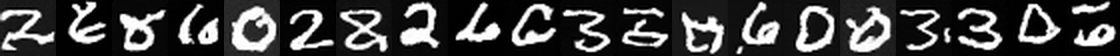

=> Inference with cfg -7


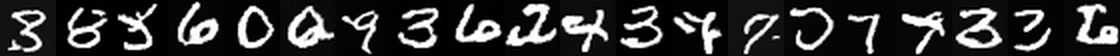

=> Inference with cfg -5


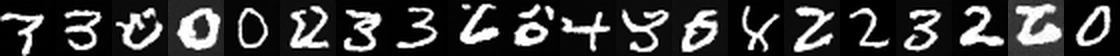

=> Inference with cfg -3


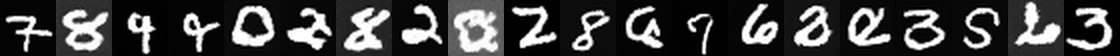

=> Inference with cfg -1


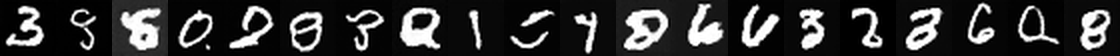

=> Inference with cfg 0


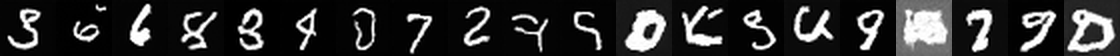

=> Inference with cfg 1


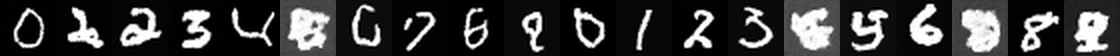

=> Inference with cfg 3


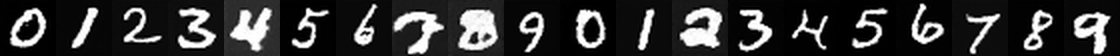

=> Inference with cfg 5


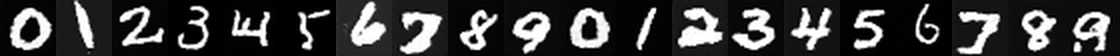

=> Inference with cfg 7


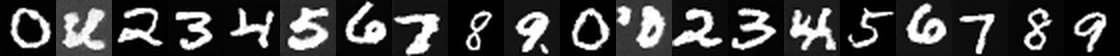

=> Inference with cfg 10


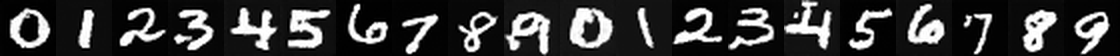

In [7]:
## --------------------------------------------------------------------------------
## Inference with different cfg scale
## --------------------------------------------------------------------------------
model = models[0.1]  # get model with 10% condition drop rate
for cfg in [-10, -7, -5, -3, -1, 0, 1, 3, 5, 7, 10]:
    print(f"=> Inference with cfg {cfg}")
    sampler(model, scheduler, cfg=cfg)

**Observations:**

- It is obvious that a *positive* classifier-free guidance helps to achieve *good* performance.
- A *proper* guidance scale such as *3* and *5* are more *effective*.